In [118]:

import mne_nirs
import mne
from mne_bids import BIDSPath, get_entity_vals
from mne.preprocessing.nirs import optical_density, temporal_derivative_distribution_repair
from itertools import compress
import numpy as np
import matplotlib.pyplot as plt


## Load the data


In [117]:
def epoch_preprocessing(subject_index, t_min,t_max):
    
    """
    Arguments:
    Subject index: int = Index of the subject to be processed [0, 1, 2, 3, 4, 5, 6, 7]
    t_min: float =  Time to initialize the epoch
    t_max: float = Time to end the epoch
    
    Returns:
    haemo:= The preprocessed haemoglobin data
    epochs: mne.Epochs object = The preprocessed epochs. You can use this to get the data and labels for the classification task.
    X: np.array = The preprocessed data. Shape: (n_trials, n_channels, n_times)
    Y: np.array = The labels for the classification task. Shape: (n_trials,)
    Y labels : 1.0-> Audio, 3.0 -> Control (Silence)
    """
    
    root = mne_nirs.datasets.audio_or_visual_speech.data_path()
    
    print(root)
    
    subject= get_entity_vals(root, "subject")[subject_index]
   
        
    dataset = BIDSPath(
            root=root,
            suffix="nirs",
            extension=".snirf",
            subject=subject,
            task="AudioVisualBroadVsRestricted",
            datatype="nirs",
            session="01"
                            )
                
    #Raw intensity data
    raw_intensity = mne.io.read_raw_snirf(dataset.fpath)
    
    raw_intensity.annotations.rename(
        {"1.0": "Audio", "2.0": "Video", "3.0": "Control", "15.0": "Ends"}
    )
    
    
    # Converting raw intensity to optical density
    raw_od = optical_density(raw_intensity)


    #Compute scalp coupling index to identify optodes that were not well attached to the scalp
    #Rejection criterion of < 0.8
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.8))
    
    print("Number of channels before removing bad channels: ", len(raw_od.ch_names))
    #raw_od = raw_od.info.pop('bads')

    raw_od = raw_od.drop_channels(raw_od.info['bads'])

    print("Number of channels after removing bad channels: ", len(raw_od.ch_names))
        

    #Temporal Derivative Distribution Repair
    
    corrected_tddr = temporal_derivative_distribution_repair(raw_od)
    
    #Apply short channel correction  to remove the influence from non-cortical changes in blood oxygenation.
    
    # A short separation channels measures solely the extracerebral signals, which includes 
    # blood presure waves, mayer waves, respiration and cardiac cycles.
    # The signal components od the short separation channel can be seen as the noise in the signal of the 
    # long channel.BY removing these components from the log channel, you cna minimize the noise.
    
    
    od_corrected = mne_nirs.signal_enhancement.short_channel_regression(corrected_tddr)
    #Convert optical density to haemoglobin concentration using the Beer-Lambert Law
    haemo = mne.preprocessing.nirs.beer_lambert_law(od_corrected, ppf=6)
    
    haemo = mne_nirs.channels.get_long_channels(haemo)
    
    #Bandpass filter the haemoglobin data between 0.02 and 0.4 Hz
    #to removoe slow drifts and components related to the heart rate
    haemo = haemo.filter(0.02,0.4)
    
    #Signal enhancement method (negative correlation enhancement algorithm) Cui et. al. 2010
    
    haemo = mne_nirs.signal_enhancement.enhance_negative_correlation(haemo)
    

        
    events, event_dict = mne.events_from_annotations(haemo)
    
    #An epoch rejection criterion  was employed to exclude epochs with a signal amplitude > 100 uM
    epochs = mne.Epochs(
        haemo,
        events,
        event_id=event_dict,
        tmin=t_min,
        tmax=t_max,
        reject=dict(hbo=100e-6, hbr=100e-6), # Epoc rejection criterion
        reject_by_annotation=True,
        proj=False,
        baseline=None,
        detrend=None,
        preload=True,
        verbose=True,
    )
    
    # I am just selecting the Audio and Control epochs
    epochs = epochs[["Audio", "Control"]]
    
    return haemo, epochs

In [119]:
def audio_data(subject_index, t_min, t_max):
    """
    Arguments:
    subject_index: int = Index of the subject to be processed [0, 1, 2, 3, 4, 5, 6, 7]
    t_min: float =  Time to initialize the epoch
    t_max: float = Time to end the epoch
    
    Returns:
    
    X: np.array = The preprocessed data. Shape: (n_trials, n_channels, n_times)
    Y: np.array = The labels for the classification task. Shape: (n_trials,)
    Y labels : 1.0-> Audio, 3.0 -> Control (Silence)
    """
    
    haemo, epochs = epoch_preprocessing(subject_index, t_min, t_max)
    
    X = epochs.get_data()
    Y = epochs.events[:, 2]
    print("Shape of the data: ", X.shape)
    print("Shape of the labels: ", Y.shape)

    # Change the labels to 0 and 1
    Y = (Y == 1).astype(int)

    return X, Y,epochs
    

## Train function 

In [120]:

import pandas as pd 
import os

from sklearn.model_selection import (KFold, StratifiedKFold, StratifiedGroupKFold,
                                     GridSearchCV, train_test_split)

from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler,EditedNearestNeighbours

import seaborn as sns
from sklearn.metrics import roc_auc_score

In [121]:
def machine_learning_exp(model,X,Y,output_folder,dataset,sampling):
    
    """
    Function train SVM, LDA and KNN models with nested cross-validation.
    
    The outer cross-validation  with 5 folds is used to evaluate the model performance, while the inner 
    cross-validation with 3 folds is used to tune the hyperparameters.
    
    Parameters
    ----------
    model : str
        The model to be used. Can be 'svc', 'lda' or 'knn'.
    X : np.array
        The features to be used for training and testing the model. shape (n_trials, n_channels, n_timepoints)
    Y : np.array
        The labels to be used for training and testing the model.
    output_folder : str
        The folder where the results will be saved.
    dataset : str
        The name of the dataset. Can be 'audio_study'. 
        
    sampling : str
        The sampling method to be used. Can be 'Random_over', 'SMOTE', 'ADASYN', 'BorderlineSmote', 
        'Random_under'
        
    Returns
    -------
    accuracies : list
        The accuracies of the model on the test sets.
    all_hps : list
        The best hyperparameters of the model on the test sets.
    auc : list
        The AUC of the model on the test sets.
    svc_coeff : list
        The coefficients of the learned features from the SVC model or LDA model
    
    """
    

    # outer and inner cross-validation parameters
    OUTER_K = 5
    INNER_K = 3
    SEED = 22

    # Standard machine learning parameters
    MAX_ITER = 250000  # for support vector classifier
    
    # Regularization parameters values tested for the SVC
    C_LIST = [1e-3, 1e-2, 1e-1, 1e0]
    # Number of neighbors values tested for the KNN
    N_NEIGHBORS_LIST = list(range(1, 10))


    all_y_true = []
    all_y_pred = []
    accuracies = []
    additional_metrics = []
    all_hps = []
    auc = []
    
    svc_coeff =[]
    lda_coeff = []

    out_kf = StratifiedKFold(n_splits=OUTER_K,shuffle=True,random_state=SEED)
    in_kf = StratifiedKFold(n_splits=INNER_K,shuffle=True,random_state=SEED)

    out_split = out_kf.split(X, Y)

    for k, out_idx in enumerate(out_split):
        
        print(f'Outer fold {k+1}/{OUTER_K}')
        X_train, X_test = X[out_idx[0]], X[out_idx[1]]
        Y_train, Y_test = Y[out_idx[0]], Y[out_idx[1]]
        
        X_train, Y_train = shuffle(X_train, Y_train, random_state=SEED)
        
        all_y_true.extend(Y_test)
        
        
        #Normalize 
        
        maxs = X_train.max(axis =(0,2),keepdims=True)
        mins = X_train.min(axis =(0,2),keepdims=True)
        
        X_train = (X_train - mins)/(maxs-mins)
        X_test = (X_test - mins)/(maxs-mins)
        
        X_train = X_train.reshape(X_train.shape[0],-1)
        X_test = X_test.reshape(X_test.shape[0],-1)
        
        
        if dataset =='audio_study':
    
        
            if sampling == 'Random_over':
                
                print("Random Oversampling")
                
                ros = RandomOverSampler(random_state=SEED)
                X_train,Y_train = ros.fit_resample(X_train, Y_train)
                
            elif sampling == 'SMOTE':
                
                print("Smote Oversampling")
                
                X_train, Y_train = SMOTE().fit_resample(X_train,Y_train)
                
            elif sampling == 'ADASYN':
                
                print("ADASYN Oversampling")
                
                X_train, Y_train = ADASYN().fit_resample(X_train,Y_train)
                
            elif sampling =='BorderlineSmote':
                
                print("BorderlineSmote Oversampling")
                
                X_train, Y_train = BorderlineSMOTE.fit_resample(X_train,Y_train)
                
            elif sampling=='Random_under':
                
                print("Random Undersampling")
                
                rus = RandomUnderSampler(random_state=SEED)
                
                X_train, Y_train = rus.fit_resample(X_train,Y_train)
                
            elif sampling == 'EditedNearesNeighbours':
                
                print("Edited Nearest Neighbours undersampling")
                
                enn = EditedNearestNeighbours()
                
                X_train, Y_train = enn.fit_resample(X_train,Y_train)
                
            elif sampling == 'No':
                
                print("No sampling method applied")
                
                X_train,Y_train = X_train, Y_train

        # Inner CV
        
        in_split = in_kf.split(X_train, Y_train)
        
        if model == 'lda':
            lda = LinearDiscriminantAnalysis()
            lda.fit(X_train, Y_train)
            lda_coeff.append(lda.coef_)
            y_pred = lda.predict(X_test).tolist()
            all_hps.append(None)
            
        elif model=='knn':
            parameters = {'n_neighbors': N_NEIGHBORS_LIST}
            knn = KNeighborsClassifier()
            clf = GridSearchCV(knn, parameters,scoring = 'accuracy', cv=in_split)
            clf.fit(X_train,Y_train)
            y_pred = clf.predict(X_test).tolist()
            
            all_hps.append(clf.best_params_['n_neighbors'])
            
        elif model=='svc':
            parameters = {'C': C_LIST}
            svc = LinearSVC(max_iter=MAX_ITER, dual='auto')
            clf = GridSearchCV(svc, parameters,scoring = 'accuracy', cv=in_split)
            clf.fit(X_train,Y_train)
            best_svc= clf.best_estimator_
            svc_coeff.append(best_svc.coef_)
            print("number of features seen during fit:", best_svc.n_features_in_)
            y_pred = clf.predict(X_test).tolist()
            
            all_hps.append(clf.best_params_['C'])
        
            
            
        # Metrics
        accuracies.append(accuracy_score(Y_test, y_pred))
        auc.append(roc_auc_score(Y_test, y_pred))
        prfs = precision_recall_fscore_support(Y_test, y_pred)
        additional_metrics.append(prfs)
        all_y_pred += y_pred
        

    # Figures
    cm = confusion_matrix(all_y_true, all_y_pred, normalize='true')
    sns.heatmap(cm, annot=True, cmap='crest', vmin=0.1, vmax=0.8)
    plt.xlabel('Predicted')
    plt.ylabel('Ground truth')
    plt.title('Confusion matrix on the test sets')
    plt.savefig(f'{output_folder}/confusion_matrix_{model}.png')
    plt.close()
    

    return accuracies, all_hps, auc,svc_coeff,lda_coeff

## Main cell to train models and save results

In [122]:
out_folder = os.path.join(os.getcwd(), '0_18')
os.makedirs(out_folder, exist_ok=True)
CONFIDENCE = 0.05  # stat confidence at 95 %

SEED = 22
sampling = 'ADASYN'

dict_accuracies = {}
subjects = [0,1,2,3,4,5,6,7]


t_min = 0.0 # ONSET
t_max = 18.0 # END

classes = 2



In [123]:
for subject in subjects:
    
    audio_folder = os.path.join(out_folder,f'_folder_subj_{subject}')
    os.makedirs(audio_folder, exist_ok=True)
    
    lda_coeff_path = os.path.join(out_folder,f'_lda_coeff_{subject}')
    os.makedirs(lda_coeff_path, exist_ok=True)
    
    DATASETS = {'audio_study': [t_min,t_max]}
    
    with open(f'{audio_folder}/summary_subj_{subject}.md', 'w') as w:
        w.write('# AUC table\n\n(Standard deviation on the cross-validation)')
        w.write('\n\n|Dataset|Chance level|')
        w.write('LDA (sd)|SVC (sd)|\n')
        w.write('|:---:|:---:|:---:|:---:|:---:|:---:|\n')
    with open(f'{audio_folder}/results_subj_{subject}.csv', 'w') as w:
        w.write('dataset;model;fold;AUC;hyperparameters\n')
        
    for dataset in DATASETS.keys():
        print(f'Processing {dataset} dataset')
        params = DATASETS[dataset]

        
        if dataset == 'audio_study':
            t_min, t_max = params

            X,Y,_= audio_data(subject,t_min,t_max)
            #X = X[:,:,int(3.9*abs(t_min)):]
            print("X shape", X.shape)
            
            

        _, hps_svc,svc,svc_coeff,_ = machine_learning_exp("svc",X,Y,audio_folder,dataset,sampling)
        _, hps_lda,lda,_,lda_coeff = machine_learning_exp("lda", X, Y, audio_folder,dataset,sampling)
        #_, hps_knn,knn,_,_= machine_learning_exp("knn", X, Y,audio_folder,dataset,sampling)
        
        
        #Saving the coefficients of the trained models
        np.savez(audio_folder, folder_1 = svc_coeff[0],folder_2 = svc_coeff[1],
                 folder_3 = svc_coeff[2], folder_4 = svc_coeff[3], folder_5= svc_coeff[4])
        
        np.savez(lda_coeff_path, folder_1 = lda_coeff[0],folder_2 = lda_coeff[1],
                 folder_3 = lda_coeff[2], folder_4 = lda_coeff[3], folder_5= lda_coeff[4])
    
        results = {'LDA': [lda, hps_lda], 'SVC': [svc, hps_svc]}
        
        chance_level = np.around(1/classes, decimals=3)
        w_summary = open(f'{audio_folder}/summary_subj_{subject}.md', 'a')
        w_results = open(f'{audio_folder}/results_subj_{subject}.csv', 'a')
        w_summary.write(f'|{dataset}|{chance_level}|')
        for model in results.keys():
            w_summary.write(
                f'{np.around(np.mean(results[model][0]), decimals=3)} '
                f'({np.around(np.std(results[model][0]), decimals=3)})|')
            for fold, auc in enumerate(results[model][0]):
                hps = results[model][1][fold]
                w_results.write(f'{dataset};{model};{fold+1};{auc};"{hps}"\n')
        w_summary.write('\n')
        w_summary.close()
        w_results.close()
        dict_accuracies[dataset] = lda + svc 

    dict_accuracies['Model'] = list(np.repeat(list(results.keys()), len(lda)))
    df_accuracies = pd.DataFrame(dict_accuracies)
    df_accuracies = df_accuracies.melt(
        id_vars=['Model'], value_vars=list(DATASETS.keys()),
        var_name='Dataset', value_name='AUC')
    plt.figure(figsize=(16, 6))
    sns.barplot(data=df_accuracies, y='AUC', x='Dataset', hue='Model',
                capsize=.1, palette='colorblind')
    plt.axhline(1/2, color='blue', linestyle=':', label='2 classes chance level')
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc=6)
    plt.savefig(f'{audio_folder}/summary.png', bbox_inches='tight', dpi=1200)
    plt.close()
    
   
    

Processing audio_study dataset
/home/sposso22/mne_data/fNIRS-audio-visual-speech
Loading /home/sposso22/mne_data/fNIRS-audio-visual-speech/sub-01/ses-01/nirs/sub-01_ses-01_task-AudioVisualBroadVsRestricted_nirs.snirf


Reading 0 ... 7976  =      0.000 ...  2041.856 secs...
Number of channels before removing bad channels:  104
Number of channels after removing bad channels:  90
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.02
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.40 Hz
- Upper transition bandwidth: 1.55 Hz (-6 dB cutoff frequency: 1.18 Hz)
- Filter length: 645 samples (165.120 s)

Used Annotations descriptions: [np.str_('Audio'), np.str_('Control'), np.str_('Ends'), np.str_('Video')]
Not setting metadata
48 matching events found
No baseline correction applied
Using data from preloaded Raw for 48 events and 71 original time points ...
0 bad epochs drop

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


number of features seen during fit: 5396
Outer fold 2/5
ADASYN Oversampling
number of features seen during fit: 5396
Outer fold 3/5
ADASYN Oversampling


/home/sposso22/miniconda3/envs/fNIRS_spatial_temp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


number of features seen during fit: 5396
Outer fold 4/5
ADASYN Oversampling
number of features seen during fit: 5396
Outer fold 5/5
ADASYN Oversampling
number of features seen during fit: 5396
Outer fold 1/5
ADASYN Oversampling
Outer fold 2/5
ADASYN Oversampling


/home/sposso22/miniconda3/envs/fNIRS_spatial_temp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Outer fold 3/5
ADASYN Oversampling
Outer fold 4/5
ADASYN Oversampling
Outer fold 5/5
ADASYN Oversampling
Processing audio_study dataset
/home/sposso22/mne_data/fNIRS-audio-visual-speech
Loading /home/sposso22/mne_data/fNIRS-audio-visual-speech/sub-02/ses-01/nirs/sub-02_ses-01_task-AudioVisualBroadVsRestricted_nirs.snirf
Reading 0 ... 7540  =      0.000 ...  1930.240 secs...
Number of channels before removing bad channels:  104
Number of channels after removing bad channels:  68
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.02
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.40 Hz
- Upper transition bandwidth: 1.55 Hz (-6 dB cutoff frequency: 1.18

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


number of features seen during fit: 3834
Outer fold 2/5
ADASYN Oversampling
number of features seen during fit: 3834
Outer fold 3/5
ADASYN Oversampling
number of features seen during fit: 3834
Outer fold 4/5
ADASYN Oversampling
number of features seen during fit: 3834
Outer fold 5/5
ADASYN Oversampling
number of features seen during fit: 3834
Outer fold 1/5
ADASYN Oversampling
Outer fold 2/5
ADASYN Oversampling
Outer fold 3/5
ADASYN Oversampling
Outer fold 4/5
ADASYN Oversampling
Outer fold 5/5
ADASYN Oversampling
Processing audio_study dataset
/home/sposso22/mne_data/fNIRS-audio-visual-speech
Loading /home/sposso22/mne_data/fNIRS-audio-visual-speech/sub-03/ses-01/nirs/sub-03_ses-01_task-AudioVisualBroadVsRestricted_nirs.snirf
Reading 0 ... 7478  =      0.000 ...  1914.368 secs...
Number of channels before removing bad channels:  104
Number of channels after removing bad channels:  94
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.4 Hz

FIR filter 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


number of features seen during fit: 5680
Outer fold 2/5
ADASYN Oversampling
number of features seen during fit: 5680
Outer fold 3/5
ADASYN Oversampling
number of features seen during fit: 5680
Outer fold 4/5
ADASYN Oversampling
number of features seen during fit: 5680
Outer fold 5/5
ADASYN Oversampling
number of features seen during fit: 5680
Outer fold 1/5
ADASYN Oversampling
Outer fold 2/5
ADASYN Oversampling
Outer fold 3/5
ADASYN Oversampling
Outer fold 4/5
ADASYN Oversampling
Outer fold 5/5
ADASYN Oversampling


/home/sposso22/miniconda3/envs/fNIRS_spatial_temp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing audio_study dataset
/home/sposso22/mne_data/fNIRS-audio-visual-speech
Loading /home/sposso22/mne_data/fNIRS-audio-visual-speech/sub-04/ses-01/nirs/sub-04_ses-01_task-AudioVisualBroadVsRestricted_nirs.snirf
Reading 0 ... 7340  =      0.000 ...  1879.040 secs...
Number of channels before removing bad channels:  104
Number of channels after removing bad channels:  56
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.02
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.40 Hz
- Upper transition bandwidth: 1.55 Hz (-6 dB cutoff frequency: 1.18 Hz)
- Filter length: 645 samples (165.120 s)

Used Annotations descriptions: [np.str_('Audio'), np.str_(

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


number of features seen during fit: 3550
Outer fold 2/5
ADASYN Oversampling
number of features seen during fit: 3550
Outer fold 3/5
ADASYN Oversampling
number of features seen during fit: 3550
Outer fold 4/5
ADASYN Oversampling
number of features seen during fit: 3550
Outer fold 5/5
ADASYN Oversampling
number of features seen during fit: 3550
Outer fold 1/5
ADASYN Oversampling
Outer fold 2/5
ADASYN Oversampling
Outer fold 3/5
ADASYN Oversampling


/home/sposso22/miniconda3/envs/fNIRS_spatial_temp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Outer fold 4/5
ADASYN Oversampling
Outer fold 5/5
ADASYN Oversampling


/home/sposso22/miniconda3/envs/fNIRS_spatial_temp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing audio_study dataset
/home/sposso22/mne_data/fNIRS-audio-visual-speech
Loading /home/sposso22/mne_data/fNIRS-audio-visual-speech/sub-05/ses-01/nirs/sub-05_ses-01_task-AudioVisualBroadVsRestricted_nirs.snirf
Reading 0 ... 7705  =      0.000 ...  1972.480 secs...
Number of channels before removing bad channels:  104
Number of channels after removing bad channels:  72
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.02
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.40 Hz
- Upper transition bandwidth: 1.55 Hz (-6 dB cutoff frequency: 1.18 Hz)
- Filter length: 645 samples (165.120 s)

Used Annotations descriptions: [np.str_('Audio'), np.str_(

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


number of features seen during fit: 4686
Outer fold 2/5
ADASYN Oversampling
number of features seen during fit: 4686
Outer fold 3/5
ADASYN Oversampling
number of features seen during fit: 4686
Outer fold 4/5
ADASYN Oversampling
number of features seen during fit: 4686
Outer fold 5/5
ADASYN Oversampling
number of features seen during fit: 4686
Outer fold 1/5
ADASYN Oversampling
Outer fold 2/5
ADASYN Oversampling
Outer fold 3/5
ADASYN Oversampling
Outer fold 4/5
ADASYN Oversampling
Outer fold 5/5
ADASYN Oversampling
Processing audio_study dataset
/home/sposso22/mne_data/fNIRS-audio-visual-speech
Loading /home/sposso22/mne_data/fNIRS-audio-visual-speech/sub-06/ses-01/nirs/sub-06_ses-01_task-AudioVisualBroadVsRestricted_nirs.snirf
Reading 0 ... 8075  =      0.000 ...  2067.200 secs...
Number of channels before removing bad channels:  104
Number of channels after removing bad channels:  100
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.4 Hz

FIR filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


number of features seen during fit: 5964
Outer fold 2/5
ADASYN Oversampling


/home/sposso22/miniconda3/envs/fNIRS_spatial_temp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


number of features seen during fit: 5964
Outer fold 3/5
ADASYN Oversampling
number of features seen during fit: 5964
Outer fold 4/5
ADASYN Oversampling
number of features seen during fit: 5964
Outer fold 5/5
ADASYN Oversampling
number of features seen during fit: 5964
Outer fold 1/5
ADASYN Oversampling
Outer fold 2/5
ADASYN Oversampling
Outer fold 3/5
ADASYN Oversampling


/home/sposso22/miniconda3/envs/fNIRS_spatial_temp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Outer fold 4/5
ADASYN Oversampling
Outer fold 5/5
ADASYN Oversampling
Processing audio_study dataset
/home/sposso22/mne_data/fNIRS-audio-visual-speech
Loading /home/sposso22/mne_data/fNIRS-audio-visual-speech/sub-07/ses-01/nirs/sub-07_ses-01_task-AudioVisualBroadVsRestricted_nirs.snirf
Reading 0 ... 7559  =      0.000 ...  1935.104 secs...
Number of channels before removing bad channels:  104
Number of channels after removing bad channels:  104
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.02
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.40 Hz
- Upper transition bandwidth: 1.55 Hz (-6 dB cutoff frequency: 1.18 Hz)
- Filter length: 645 samples 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


number of features seen during fit: 6248
Outer fold 2/5
ADASYN Oversampling


/home/sposso22/miniconda3/envs/fNIRS_spatial_temp/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


number of features seen during fit: 6248
Outer fold 3/5
ADASYN Oversampling
number of features seen during fit: 6248
Outer fold 4/5
ADASYN Oversampling
number of features seen during fit: 6248
Outer fold 5/5
ADASYN Oversampling
number of features seen during fit: 6248
Outer fold 1/5
ADASYN Oversampling
Outer fold 2/5
ADASYN Oversampling
Outer fold 3/5
ADASYN Oversampling
Outer fold 4/5
ADASYN Oversampling
Outer fold 5/5
ADASYN Oversampling
Processing audio_study dataset
/home/sposso22/mne_data/fNIRS-audio-visual-speech
Loading /home/sposso22/mne_data/fNIRS-audio-visual-speech/sub-08/ses-01/nirs/sub-08_ses-01_task-AudioVisualBroadVsRestricted_nirs.snirf
Reading 0 ... 8267  =      0.000 ...  2116.352 secs...
Number of channels before removing bad channels:  104
Number of channels after removing bad channels:  64
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


number of features seen during fit: 3550
Outer fold 2/5
ADASYN Oversampling
number of features seen during fit: 3550
Outer fold 3/5
ADASYN Oversampling
number of features seen during fit: 3550
Outer fold 4/5
ADASYN Oversampling
number of features seen during fit: 3550
Outer fold 5/5
ADASYN Oversampling
number of features seen during fit: 3550
Outer fold 1/5
ADASYN Oversampling
Outer fold 2/5
ADASYN Oversampling
Outer fold 3/5
ADASYN Oversampling
Outer fold 4/5
ADASYN Oversampling
Outer fold 5/5
ADASYN Oversampling


## Results

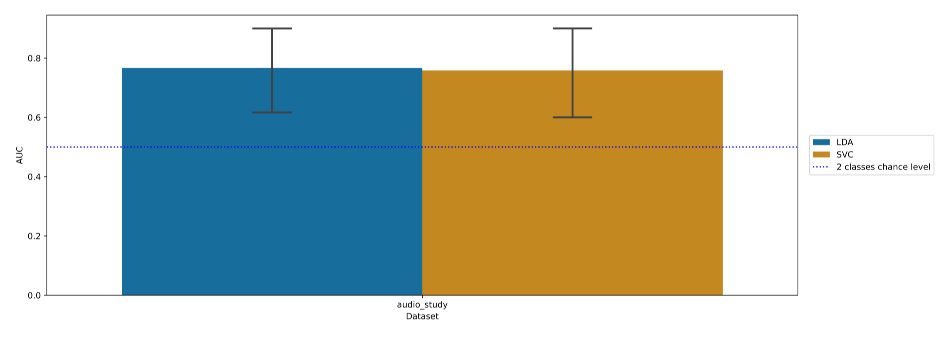

In [124]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Adjust the width and height as needed
plt.imshow(mpimg.imread("0_18/_folder_subj_0/summary.png"))
plt.axis('off')
plt.show()


In [125]:
md_file_path = "0_18/_folder_subj_0/summary_subj_0.md"

# Open and read the file
with open(md_file_path, 'r') as file:
    md_content = file.read()

# Print the content
print(md_content)

# AUC table

(Standard deviation on the cross-validation)

|Dataset|Chance level|LDA (sd)|SVC (sd)|
|:---:|:---:|:---:|:---:|:---:|:---:|
|audio_study|0.5|0.767 (0.162)|0.758 (0.172)|



### Results from each outer cross-validation folder

In [126]:
import pandas as pd

cv = pd.read_csv("0_18/_folder_subj_0/results_subj_0.csv", sep=';')
print(cv)

       dataset model  fold       AUC  hyperparameters
0  audio_study   LDA     1  0.750000              NaN
1  audio_study   LDA     2  0.500000              NaN
2  audio_study   LDA     3  0.750000              NaN
3  audio_study   LDA     4  0.833333              NaN
4  audio_study   LDA     5  1.000000              NaN
5  audio_study   SVC     1  0.875000            0.010
6  audio_study   SVC     2  0.500000            0.100
7  audio_study   SVC     3  0.750000            0.010
8  audio_study   SVC     4  0.666667            0.010
9  audio_study   SVC     5  1.000000            0.001


## Topographic maps

We  visualize learned features from the linear SVC in a topographic map format, focusing on the time intervals where more feature values  $\geq 0.8$ ). To determine the relevant window time, we first sum the number of features with values $\geq 0.8 $ across the spatial dimension. Next, we apply a mean filter ( $ window_size = 2 s$) to smooth the temporal profile and compute the average counts over time. Finally, we identify the target interval by finding the intersection between 80 \% of the maximum value and the time axis. Notably, all participants exhibit asymmetrical patterns across both hemispheres, particularly in the relevant channels highlighted in red. This asymmetry suggests potential left lateralization in the decoding task's neural processes at specific times. We also see that the HbO features are most relevant when the stimulus ends, and the opposite is true for HbR features.

In [ ]:
from mne_nirs.channels import picks_pair_to_idx

def save_maps(t_min,t_max,subject,weight_path):
    

    figures_folder = 'Average_Figures_SVC'
    
    X,_,epochs = audio_data(subject,t_min,t_max)
    ch_names = epochs.ch_names
    epochs.pick(picks='hbo')
   
    
    # load features coefficients from the trained models saved in the npz file
    weights = np.load(weight_path)
    
    all_weights = []

    for folder in weights.files:
   
        
        folder_weights = weights[folder]
        folder_weights = folder_weights.reshape(X.shape[1], X.shape[2])
        all_weights.append(folder_weights)
    
    # Stack all weights from each cross_validation folder into a single array
    
    all_weights = np.stack(all_weights, axis=0)
    
    folder_weights = np.mean(all_weights, axis=0)
    
    # Split hbo and hbr
    
    hbo_weights = folder_weights[:X.shape[1]//2,:]
    hbr_weights  = folder_weights[X.shape[1]//2:,:]
    
    hbo_names = ch_names[:X.shape[1]//2]
    hbr_names = ch_names[X.shape[1]//2:]
    
    
   
    #Normalize weights
    hbo_weights = (hbo_weights - np.min(hbo_weights)) / (np.max(hbo_weights) - np.min(hbo_weights))
    hbr_weights = (hbr_weights - np.min(hbr_weights)) / (np.max(hbr_weights) - np.min(hbr_weights))
    
    
    binary_hbo_weights = hbo_weights >= 0.8
    binary_hbr_weights = hbr_weights >= 0.8
        
    
    
        
    #Plot attention maps
    plt.figure()
    plt.imshow(folder_weights, aspect='auto', extent=[0, t_max, 0, folder_weights.shape[0]])
    plt.colorbar(label='Weight')
    plt.xlabel('Time')
    plt.ylabel('Channels')
    plt.yticks(ticks=np.arange(len(ch_names)), labels=ch_names, fontsize=4)  # Reduce font size of y-axis labels
    plt.title(f'Subject {subject}')
    if subject == 0:
        plt.savefig(os.path.join(figures_folder, f'subject_{subject}_weights.png'), dpi=500)
    plt.show()
    plt.close()
    
    plt.figure()
    
    plt.imshow(binary_hbo_weights, aspect='auto', extent=[0, t_max, 0, binary_hbo_weights.shape[0]])
    plt.colorbar(label='Weight')
    plt.xlabel('Time')
    plt.ylabel('Channels')
    plt.yticks(ticks=np.arange(len(hbo_names)), labels=hbo_names, fontsize=4)  # Reduce font size of y-axis labels
    plt.title(f'HbO weights, Subject {subject}')
    if subject == 0:
        plt.savefig(os.path.join(figures_folder, f'subject_{subject}_binary_weights.png'), dpi=500)
        
    plt.show()
    plt.close()
    
    plt.figure()
    plt.imshow(binary_hbr_weights, aspect='auto', extent=[0, t_max, 0, binary_hbr_weights.shape[0]])
    plt.colorbar(label='Weight')   
    plt.xlabel('Time')
    plt.ylabel('Channels')
    plt.yticks(ticks=np.arange(len(hbr_names)), labels=hbr_names, fontsize=4)  # Reduce font size of y-axis labels
    plt.title(f'HbR weights, Subject {subject}')
    if subject == 0:
        plt.savefig(os.path.join(figures_folder, f'subject_{subject}_binary_weights_hbr.png'), dpi=500)
    plt.show()
    plt.close()
    
    
    #Choose window 
    hbo_channel_counts = np.sum(binary_hbo_weights, axis=0)
    hbr_channel_counts = np.sum(binary_hbr_weights, axis=0)

    window_size = 8
    hbo_averaged_counts = np.convolve(hbo_channel_counts, np.ones(window_size)/window_size, mode='same')
    hbr_averaged_counts = np.convolve(hbr_channel_counts, np.ones(window_size)/window_size, mode='same')

   
    
    # Find the maximum value and its index
    max_hbo_value = np.max(hbo_averaged_counts)
    max_hbo_index = np.argmax(hbo_averaged_counts)
    print(f'Max hbo value: {max_hbo_value}, Max hbo index: {max_hbo_index}')
    
    max_hbr_value = np.max(hbr_averaged_counts)
    max_hbr_index = np.argmax(hbr_averaged_counts)
    print(f'Max hbr value: {max_hbr_value}, Max hbr index: {max_hbr_index}')
    
    # Find the intersection between 80% of the maximum value and the time axis
    hbo_threshold = 0.8 * max_hbo_value
    print("Threshold:", hbo_threshold)
    
    hbr_threshold = 0.8 * max_hbr_value
    print("Threshold:", hbr_threshold)


    #Find the left intersection for hbo

    j = int(max_hbo_index - 1)

    while j > 0:
        print("Value at ", j, ":", hbo_averaged_counts[j])
        if np.isclose(hbo_averaged_counts[j], hbo_threshold,atol=0.4) and hbo_averaged_counts[j] < max_hbo_value:
            print("HBO-First intersection at ", j)
            init = j
            break

        j -= 1
    
    #Find the right intersection for hbo
    i = int(max_hbo_index + 1)
    while  i  < len(hbo_averaged_counts):

        print("Value at ", i, ":", hbo_averaged_counts[i])
        if np.isclose(hbo_averaged_counts[i], hbo_threshold, atol=1.5) and hbo_averaged_counts[i] < max_hbo_value:
            print("Second  intersection at ", i)
            final = i
            break

    
        i += 1
        
    #Find the left intersection for hbr
        
    j_hbr = int(max_hbr_index - 1)
    
    while j_hbr > 0:
        print("Value at ", j_hbr, ":", hbr_averaged_counts[j_hbr])
        if np.isclose(hbr_averaged_counts[j_hbr], hbr_threshold,atol=0.4) and hbr_averaged_counts[j_hbr] < max_hbr_value:
            print("HBR-First intersection at ", j_hbr)
            init_hbr = j_hbr
            break

        j_hbr -= 1
        
    #Find the right intersection for hbr
    i_hbr = int(max_hbr_index + 1)
    while  i_hbr  < len(hbr_averaged_counts):
        print("Value at ", i_hbr, ":", hbr_averaged_counts[i_hbr])
        if np.isclose(hbr_averaged_counts[i_hbr], hbr_threshold, atol=1.5) and hbr_averaged_counts[i_hbr] < max_hbr_value:
            print("Second  intersection at ", i_hbr)
            final_hbr = i_hbr
            break

    
        i_hbr += 1

    print("Number of channels at first interseciton for hbo :", hbo_averaged_counts[init])
    print("Number of channels at final interseciton for hbo:", hbo_averaged_counts[final])
    
    print("(hbo) First intersection at ", init)
    print("(hbo) Final intersection at ", final)
    
    print("Number of channels at first interseciton for hbr:", hbr_averaged_counts[init_hbr])
    print("Number of channels at final interseciton for hbr:", hbr_averaged_counts[final_hbr])
    
    print("(hbr) First intersection at ", init_hbr)
    print("(hbr) Final intersection at ", final_hbr)


    hbo_percent_init = int(init/4)
    hbo_percent_fin = int(final/4)

    hbo_percent_window = (hbo_percent_init,hbo_percent_fin)
    
    hbr_percent_init = int(init_hbr/4)
    hbr_percent_fin = int(final_hbr/4)
    
    hbr_percent_window = (hbr_percent_init,hbr_percent_fin)


    # Plot the vertical lines at the intersection points
    plt.figure()
    plt.plot(np.linspace(0, t_max, len(hbo_averaged_counts)), hbo_averaged_counts)
    plt.axvline(x=np.linspace(0, t_max, len(hbo_averaged_counts))[init], color='r', linestyle='--', label=f'80% left max value at {hbo_percent_init}')
    plt.axvline(x=np.linspace(0, t_max, len(hbo_averaged_counts))[final], color='r', linestyle='--',label=f'80% right max value at {hbo_percent_fin}')
    plt.xlabel('Time(s)')
    plt.ylabel(' Number of Channels')
    plt.title(f' Channels per window of size 2 s (HbO). Chosen window {hbo_percent_window}')
    if subject == 0:
        plt.savefig(os.path.join(figures_folder, f'subject_{subject}_Threshold_window_complete.png'), dpi=500)
    plt.legend()
    #plt.show()
    plt.close()
    
    # Plot the vertical lines at the intersection points
    plt.figure()
    plt.plot(np.linspace(0, t_max, len(hbr_averaged_counts)), hbr_averaged_counts)
    plt.axvline(x=np.linspace(0, t_max, len(hbr_averaged_counts))[init_hbr], color='r', linestyle='--', label=f'80% left max value at {hbr_percent_init}')
    plt.axvline(x=np.linspace(0, t_max, len(hbr_averaged_counts))[final_hbr], color='r', linestyle='--',label=f'80% right max value at {hbr_percent_fin}')
    plt.xlabel('Time(s)')
    plt.ylabel(' Number of Channels')
    plt.title(f' Channels per window of size 2 s (HbR). Chosen window {hbr_percent_window}')
    if subject == 0:
        #plt.savefig(os.path.join(figures_folder, f'subject_{subject}_Threshold_window_complete.png'), dpi=500)
        plt.savefig(os.path.join(figures_folder, f'subject_{subject}_Threshold_window_complete_hbr.png'), dpi=500)

    plt.legend()
    #plt.show()
    plt.close()
    
    return init,final,init_hbr,final_hbr,epochs,hbo_weights,hbr_weights

In [128]:
def fixed_attention_maps(map_type='threshold'):
    
    figures_folder = 'Average_Figures_SVC'
    os.makedirs(figures_folder, exist_ok=True)

    size = 7
    #source detectors pairs for each region of interest
    IFG_ = [[1, 1], [2, 1], [3, 1], [3, 2], [4, 1], [4, 2], [5, 1], [5, 2]]
    Auditory_A_left = [[6, 3], [6, 4], [8, 3], [8, 4]]
    Auditory_A_right = [[10, 8], [10, 9], [11, 8], [11, 9]]
    Auditory_B_left = [[7, 5], [7, 6], [8, 5], [8, 6], [8, 7], [9, 5], [9, 6], [9, 7]]
    Auditory_B_right = [[11, 10], [11, 11], [11, 12], [12, 10], [12, 11], [13, 10], [13, 11], [13, 12]]
    Visual = [[14, 13], [14, 14], [14, 15], [15, 13], [15, 14], [16, 14], [16, 15]]
    Visual_A = [[14, 13], [14, 14], [14, 15]]
    Visual_B = [[15, 13], [15, 14], [16, 14],[16, 15]]
    Auditory_left = Auditory_A_left + Auditory_B_left
    Auditory_right = Auditory_A_right + Auditory_B_right


    
    t_min = 0.0 
    t_max = 18.0
    chroma = None 
    
    fig, axes = plt.subplots(2, 8, figsize=(22, 6))

    for subject in range(8):
        
        idx = subject 
        cmap_ticks = [i/10 for i in range(0, 11)]
        
        weight_path= f'0_18/_folder_subj_{subject}.npz' 
        
        init,final,init_hbr,final_hbr,epochs,hbo_weights,hbr_weights = save_maps(t_min,t_max,subject,weight_path)
        
        
        print("hb0_weights shape:",hbo_weights.shape)
        print("hbr_weights shape:",hbr_weights.shape)
        
        
        groups = dict(
            IFG=picks_pair_to_idx(epochs, IFG_, on_missing='ignore'),
            Auditory_A_left=picks_pair_to_idx(epochs, Auditory_A_left,on_missing='ignore'),
            Auditory_A_right=picks_pair_to_idx(epochs, Auditory_A_right,on_missing='ignore'),
            Auditory_B_left=picks_pair_to_idx(epochs, Auditory_B_left,on_missing='ignore'),
            Auditory_B_right=picks_pair_to_idx(epochs, Auditory_B_right,on_missing='ignore'),
            Visual=picks_pair_to_idx(epochs, Visual,on_missing='ignore'),
            Auditory_left=picks_pair_to_idx(epochs, Auditory_left,on_missing='ignore'),
            Auditory_right=picks_pair_to_idx(epochs, Auditory_right,on_missing='ignore'))
    
        
        new_epochs = epochs.copy()
        IFG = groups["IFG"]
        new_epochs.pick(picks=IFG)
        

        auditive_epochs = epochs.copy()
        index_auditory_left = groups["Auditory_left"]
        auditive_epochs.pick(picks=index_auditory_left)


        auditive_epochs_right = epochs.copy()
        index_auditory_right = groups["Auditory_right"]
        auditive_epochs_right.pick(picks=index_auditory_right)

        visual_epochs = epochs.copy()
        if groups["Visual"] and len(groups["Visual"]) >= 2:
            visual_epochs.pick(picks=groups["Visual"])
            
            
        init_s = int(init/4)
        final_s = int(final/4)
        
        init_hbr_s = int(init_hbr/4)
        final_hbr_s = int(final_hbr/4)
        

        
        if final-init < 4:
            print("Final - Init < 4:" ,final-init)
            final = init + 4

        if (final-init)% 4==0 :
            final = final + 1
            
        if final_hbr-init_hbr < 4:
            print("Final - Init < 4:" ,final_hbr-init_hbr)
            final_hbr = init_hbr + 4
            
        if (final_hbr-init_hbr)% 4==0 :
            final_hbr = final_hbr + 1
             
        
        num_seconds = [i for i in range(init,final,4)]

        #table_data = []
        #table_data_hbr = []
        print("Averaged points to make the topographical maps:",num_seconds)
        
        if subject == 0:
            new_epochs.drop_channels('S4_D1 hbo')
            auditive_epochs_right.drop_channels('S11_D10 hbo')

        elif subject == 1:
            new_epochs.drop_channels('S4_D1 hbo')

        elif subject == 2:
            new_epochs.drop_channels('S4_D1 hbo')
            auditive_epochs.drop_channels('S7_D6 hbo')
            auditive_epochs_right.drop_channels('S11_D10 hbo')

        elif subject == 3:
            new_epochs.drop_channels('S4_D1 hbo')
            auditive_epochs.drop_channels('S7_D6 hbo')

        elif subject == 4:
            auditive_epochs.drop_channels('S7_D6 hbo')

        elif subject == 5:
            auditive_epochs.drop_channels('S8_D5 hbo')
            auditive_epochs_right.drop_channels('S11_D10 hbo')

        elif subject == 6:
            new_epochs.drop_channels('S4_D1 hbo')
            auditive_epochs.drop_channels('S7_D6 hbo')
            auditive_epochs_right.drop_channels('S11_D10 hbo')
        
        elif subject == 7:
            auditive_epochs_right.drop_channels('S12_D11 hbo')
            
        
        
        hbo_1s = hbo_weights[:, init:final+1]
        hbo_1s = np.mean(hbo_1s, axis=1)
        
        hbr_1s = hbr_weights[:, init_hbr:final_hbr+1]
        hbr_1s = np.mean(hbr_1s, axis=1)
        
        if groups["Visual"] and len(groups["Visual"]) >= 2:

            print("len of visual group:",len(groups["Visual"]))
            min_values = [np.min(hbo_1s[IFG]), np.min(hbo_1s[index_auditory_left]), np.min(hbo_1s[index_auditory_right]), np.min(hbo_1s[groups["Visual"]])]
            max_values = [np.max(hbo_1s[IFG]), np.max(hbo_1s[index_auditory_left]), np.max(hbo_1s[index_auditory_right]), np.max(hbo_1s[groups["Visual"]])]
            min_ind = np.argmin(min_values)
            max_ind = np.argmax(max_values)

            min_val = min_values[min_ind]
            max_val = max_values[max_ind]
            
        else:

            min_values = [np.min(hbo_1s[IFG]), np.min(hbo_1s[index_auditory_left]), np.min(hbo_1s[index_auditory_right])]
            max_values = [np.max(hbo_1s[IFG]), np.max(hbo_1s[index_auditory_left]), np.max(hbo_1s[index_auditory_right])]
            min_ind = np.argmin(min_values)
            max_ind = np.argmax(max_values)

            min_val = min_values[min_ind]
            max_val = max_values[max_ind]

        #Normalize each subgroup

        hbo_1s[IFG] = (hbo_1s[IFG] - min_val) / (max_val - min_val)
        hbo_1s[index_auditory_left] = (hbo_1s[index_auditory_left] - min_val) / (max_val - min_val)
        hbo_1s[index_auditory_right] = (hbo_1s[index_auditory_right] - min_val) / (max_val - min_val)
        
        if groups["Visual"] and len(groups["Visual"]) >= 2:
            hbo_1s[groups["Visual"]] = (hbo_1s[groups["Visual"]] - min_val) / (max_val - min_val)

       
        #weights of each region
        hbo_ifg = hbo_1s[IFG]
        hbo_auditory_left = hbo_1s[index_auditory_left]
        hbo_auditory_right = hbo_1s[index_auditory_right]
        if groups["Visual"] and len(groups["Visual"]) >= 2:
            hbo_visual = hbo_1s[groups["Visual"]]

        if subject == 0:
            
            hbo_ifg = np.delete(hbo_ifg,4)
            hbo_auditory_right = np.delete(hbo_auditory_right,4)

        elif subject == 1:
            hbo_ifg = np.delete(hbo_ifg,4)

        elif subject == 2:
            hbo_ifg = np.delete(hbo_ifg,4)
            hbo_auditory_left = np.delete(hbo_auditory_left,5)
            hbo_auditory_right = np.delete(hbo_auditory_right,4)

        elif subject == 3:
            hbo_ifg = np.delete(hbo_ifg,4)
            hbo_auditory_left = np.delete(hbo_auditory_left,5)

        elif subject == 4:
            hbo_auditory_left = np.delete(hbo_auditory_left,5)

        elif subject == 5:
            hbo_auditory_left = np.delete(hbo_auditory_left,5)
            hbo_auditory_right = np.delete(hbo_auditory_right,4)

        elif subject == 6:
            hbo_ifg = np.delete(hbo_ifg,4)
            hbo_auditory_left = np.delete(hbo_auditory_left,5)
            hbo_auditory_right = np.delete(hbo_auditory_right,4)
        elif subject == 7:
            hbo_auditory_right = np.delete(hbo_auditory_right,3)
            
            
        ifg_mask = np.zeros(len(hbo_ifg), dtype=bool)
        auditory_mask_left = np.zeros(len(hbo_auditory_left), dtype=bool)
        auditory_mask_right = np.zeros(len(hbo_auditory_right), dtype=bool)

        if groups["Visual"] and len(groups["Visual"]) >= 2:
            visual_mask = np.zeros(len(groups["Visual"]), dtype=bool)

        ifg_mask = hbo_ifg >= 0.8
        auditory_mask_left = hbo_auditory_left >= 0.8
        auditory_mask_right = hbo_auditory_right >= 0.8

        if groups["Visual"] and len(groups["Visual"]) >= 2:
            visual_mask = hbo_visual >= 0.8

        if subject !=7:
            img_ifg, _ = mne.viz.plot_topomap(hbo_ifg, pos=new_epochs.info, ch_type='hbo', sensors=True,
                                            res=256, axes=axes[0, idx], show=False, cmap='viridis', contours=0,
                                            extrapolate='local', mask=ifg_mask,mask_params=dict(marker='o', markerfacecolor='r', markeredgecolor='k',
                linewidth=0, markersize=2),size=size)

        # Plot Auditory_left weights
        img_auditory, _ = mne.viz.plot_topomap(hbo_auditory_left, pos=auditive_epochs.info, ch_type='hbo',
                                                        sensors=True, res=256, size=size, axes=axes[0, idx], show=False,
                                                        cmap='viridis', contours=0, extrapolate='local',mask= auditory_mask_left,mask_params=dict(marker='o', markerfacecolor='r', markeredgecolor='k',
                linewidth=0, markersize=2))

        # Plot Auditory_right weights
        if subject !=3:
            img_auditory_right, _ = mne.viz.plot_topomap(hbo_auditory_right, pos=auditive_epochs_right.info,
                                                                        ch_type='hbo', sensors=True, res=256, size=size,
                                                                        axes=axes[0, idx], show=False, cmap='viridis', contours=0,
                                                                        extrapolate='local',mask=auditory_mask_right,mask_params=dict(marker='o', markerfacecolor='r', markeredgecolor='k',
                linewidth=0, markersize=2))
         
         

        # Plot Visual weights
        if groups["Visual"] and len(groups["Visual"]) >= 2:
            img_visual, _ = mne.viz.plot_topomap(hbo_visual, pos=visual_epochs.info, ch_type='hbo',
                                                        sensors=True, res=256, size=size, axes=axes[0, idx], show=False,
                                                        cmap='viridis', contours=0, extrapolate='local', mask=visual_mask,mask_params=dict(marker='o', markerfacecolor='r', markeredgecolor='k',
                linewidth=0, markersize=2))
        if init_s != final_s:
            axes[0, subject].set_title(f'Sub.{subject} [ {init_s} - {final_s} ] s')
        else: 
            axes[0, subject].set_title(f'Sub.{subject} [ {init_s} ] s')
        #init_count += 1
        
        if subject == 2:
            
            hbo_imgs = [img_ifg,img_auditory,img_auditory_right,img_visual]
            max_hbo_ind = max_ind
        
        
        ##################################HBR############################################
        if groups["Visual"] and len(groups["Visual"]) >= 2:
            min_values = [np.min(hbr_1s[IFG]), np.min(hbr_1s[index_auditory_left]), np.min(hbr_1s[index_auditory_right]), np.min(hbr_1s[groups["Visual"]])]
            max_values = [np.max(hbr_1s[IFG]), np.max(hbr_1s[index_auditory_left]), np.max(hbr_1s[index_auditory_right]), np.max(hbr_1s[groups["Visual"]])]
            min_ind = np.argmin(min_values)
            max_ind = np.argmax(max_values)

            min_val = min_values[min_ind]
            max_val = max_values[max_ind]

        else:
            
            min_values = [np.min(hbr_1s[IFG]), np.min(hbr_1s[index_auditory_left]), np.min(hbr_1s[index_auditory_right])]
            max_values = [np.max(hbr_1s[IFG]), np.max(hbr_1s[index_auditory_left]), np.max(hbr_1s[index_auditory_right])]
            min_ind = np.argmin(min_values)
            max_ind = np.argmax(max_values)

            min_val = min_values[min_ind]
            max_val = max_values[max_ind]
            
        #Normalize each subgroup

        hbr_1s[IFG] = (hbr_1s[IFG] - min_val) / (max_val - min_val)
        hbr_1s[index_auditory_left] = (hbr_1s[index_auditory_left] - min_val) / (max_val - min_val)
        hbr_1s[index_auditory_right] = (hbr_1s[index_auditory_right] - min_val) / (max_val - min_val)
        hbr_1s[groups["Visual"]] = (hbr_1s[groups["Visual"]] - min_val) / (max_val - min_val)

        hbr_ifg = hbr_1s[IFG]
        hbr_auditory_left = hbr_1s[index_auditory_left]
        hbr_auditory_right = hbr_1s[index_auditory_right]

        if groups["Visual"] and len(groups["Visual"]) >= 2:
            hbr_visual = hbr_1s[groups["Visual"]]

        if subject == 0:
            
            hbr_ifg = np.delete(hbr_ifg,4)
            hbr_auditory_right = np.delete(hbr_auditory_right,4)

        elif subject == 1:
            hbr_ifg = np.delete(hbr_ifg,4)

        elif subject == 2: 
            hbr_ifg = np.delete(hbr_ifg,4)
            hbr_auditory_left = np.delete(hbr_auditory_left,5)
            hbr_auditory_right = np.delete(hbr_auditory_right,4)

        elif subject == 3:
            hbr_ifg = np.delete(hbr_ifg,4)
            hbr_auditory_left = np.delete(hbr_auditory_left,5)

        elif subject == 4:
            hbr_auditory_left = np.delete(hbr_auditory_left,5)

        elif subject == 5:
            hbr_auditory_left = np.delete(hbr_auditory_left,5)
            hbr_auditory_right = np.delete(hbr_auditory_right,4)

        elif subject == 6:
            hbr_ifg = np.delete(hbr_ifg,4)
            hbr_auditory_left = np.delete(hbr_auditory_left,5)
            hbr_auditory_right = np.delete(hbr_auditory_right,4)

        elif subject == 7:
            hbr_auditory_right = np.delete(hbr_auditory_right,3)
            
        #Mask for each region
        hbr_mask_ifg = np.zeros(len(hbr_ifg), dtype=bool)
        hbr_mask_auditory_left = np.zeros(len(hbr_auditory_left), dtype=bool)
        hbr_mask_auditory_right = np.zeros(len(hbr_auditory_right), dtype=bool)
        if groups["Visual"] and len(groups["Visual"]) >= 2:
            hbr_mask_visual = np.zeros(len(hbr_visual), dtype=bool)

        hbr_mask_ifg = hbr_ifg >=0.8
        hbr_mask_auditory_left = hbr_auditory_left >=0.8
        hbr_mask_auditory_right = hbr_auditory_right >=0.8

        if groups["Visual"] and len(groups["Visual"]) >= 2:

            hbr_mask_visual = hbr_visual >=0.8

        

        if subject !=7:
            hbr_img_ifg, _ = mne.viz.plot_topomap(hbr_ifg, pos=new_epochs.info, ch_type='hbo', sensors=True,
                                            res=256, size=size, axes=axes[1, idx], show=False, cmap='viridis', contours=0,
                                            extrapolate='local',mask=hbr_mask_ifg,mask_params=dict(marker='o', markerfacecolor='r', markeredgecolor='k',
                linewidth=0, markersize=2))

        
        # Plot Auditory_left weights
        hbr_img_auditory, _ = mne.viz.plot_topomap(hbr_auditory_left, pos=auditive_epochs.info, ch_type='hbo',
                                                        sensors=True, res=256, size=size, axes=axes[1, idx], show=False,
                                                        cmap='viridis', contours=0, extrapolate='local',mask=hbr_mask_auditory_left,mask_params=dict(marker='o', markerfacecolor='r', markeredgecolor='k',
                linewidth=0, markersize=2))

        # Plot Auditory_right weights
        if subject !=3:
            hbr_img_auditory_right, _ = mne.viz.plot_topomap(hbr_auditory_right, pos=auditive_epochs_right.info,
                                                                        ch_type='hbo', sensors=True, res=256, size=size,
                                                                        axes=axes[1, idx], show=False, cmap='viridis', contours=0,
                                                                        extrapolate='local',mask=hbr_mask_auditory_right,mask_params=dict(marker='o', markerfacecolor='r', markeredgecolor='k',
                linewidth=0, markersize=2))

        # Plot Visual weights
        if groups["Visual"] and len(groups["Visual"]) >= 2:

            hbr_img_visual, _ = mne.viz.plot_topomap(hbr_visual, pos=visual_epochs.info, ch_type='hbo',
                                                    sensors=True, res=256, size=size, axes=axes[1, idx], show=False,
                                                    cmap='viridis', contours=0, extrapolate='local', mask=hbr_mask_visual,mask_params=dict(marker='o', markerfacecolor='r', markeredgecolor='k',
                linewidth=0, markersize=2))
       
        if init_hbr_s != final_hbr_s:
            axes[1, idx].set_title(f'Sub.{subject} [ {init_hbr_s} - {final_hbr_s} ] s')
        else:
            axes[1, idx].set_title(f'Sub.{subject} [ {init_hbr_s} ] s')
        #init_count += 1
            
            
        
        if subject == 2:
            
            hbr_imgs = [hbr_img_ifg,hbr_img_auditory,hbr_img_auditory_right,hbr_img_visual]
            max_hbr_ind = max_ind
            
            
        print("Subject:",subject)
        
        #print("AXESSSS:",axes[0, idx])
        
              
            
    # Add colorbar for hbo_weights        
    cbar_hbo = fig.colorbar(hbo_imgs[max_hbo_ind], ax=axes[0, :], shrink=0.75, orientation='vertical', ticks=cmap_ticks)
    cbar_hbo.set_ticklabels(cmap_ticks)
    cbar_hbo.set_label('HbO')

   #####################333
        
    
    # Add colorbar for hbr_weights
    cbar_hbr = plt.colorbar(hbr_imgs[max_hbr_ind], ax=axes[1, :], shrink=0.75, orientation='vertical', ticks=cmap_ticks)
    cbar_hbr.set_ticklabels(cmap_ticks)
    cbar_hbr.set_label('HbR')

    # Add general title in a vertical way on the right side, closer to the colorbars
    fig.text(0.81, 0.5, 'svc weights', va='center', ha='center', rotation='vertical', fontsize=16)

    # Add general title "subject" to the figure
    fig.suptitle(f'Relevant features learned by the SVC across the brain regions', fontsize=20)
    
    #plt.savefig(os.path.join(figures_folder, f'_Attention_maps.png'), dpi=500)



    plt.tight_layout()
    plt.show()
    plt.close(fig)

   

/home/sposso22/mne_data/fNIRS-audio-visual-speech
Loading /home/sposso22/mne_data/fNIRS-audio-visual-speech/sub-01/ses-01/nirs/sub-01_ses-01_task-AudioVisualBroadVsRestricted_nirs.snirf
Reading 0 ... 7976  =      0.000 ...  2041.856 secs...
Number of channels before removing bad channels:  104
Number of channels after removing bad channels:  90
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.02
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.40 Hz
- Upper transition bandwidth: 1.55 Hz (-6 dB cutoff frequency: 1.18 Hz)
- Filter length: 645 samples (165.120 s)

Used Annotations descriptions: [np.str_('Audio'), np.str_('Control'), np.str_('Ends'), np

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


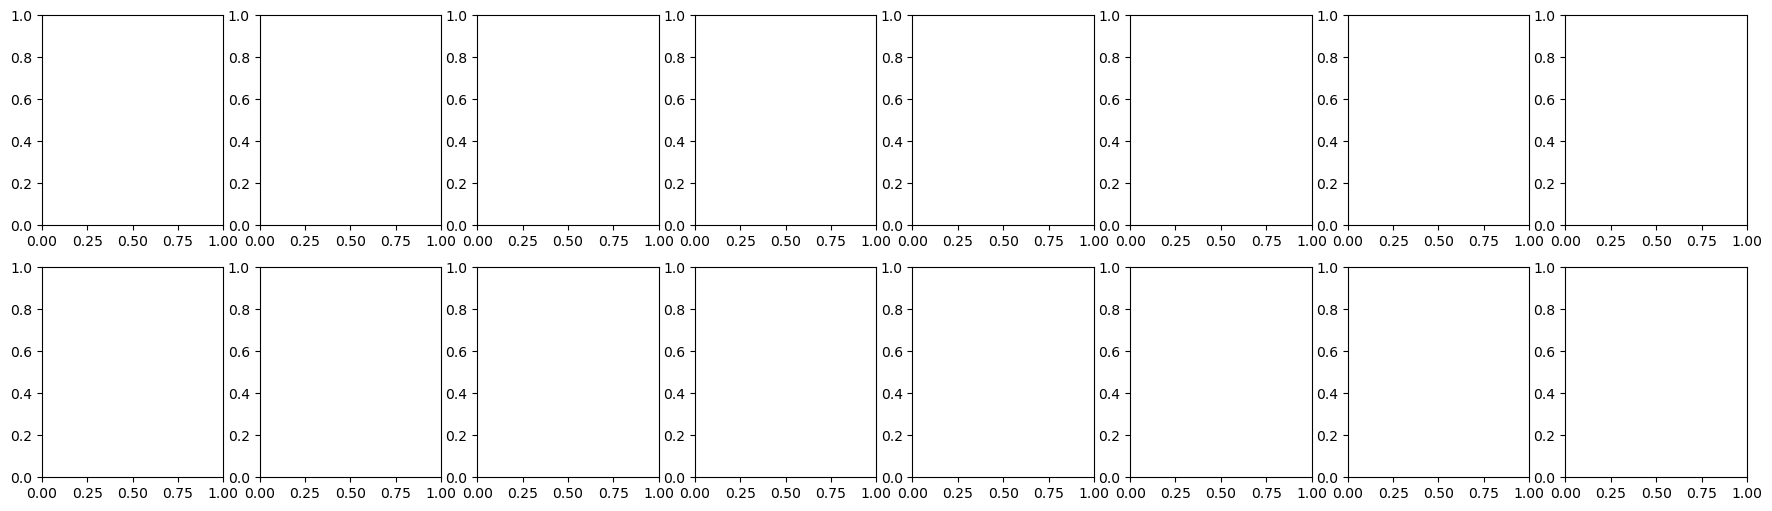

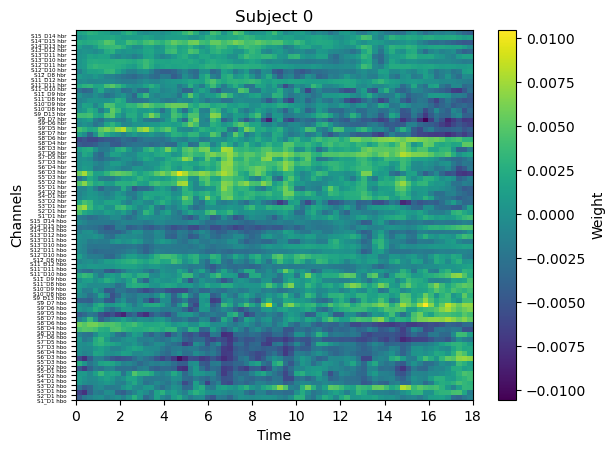

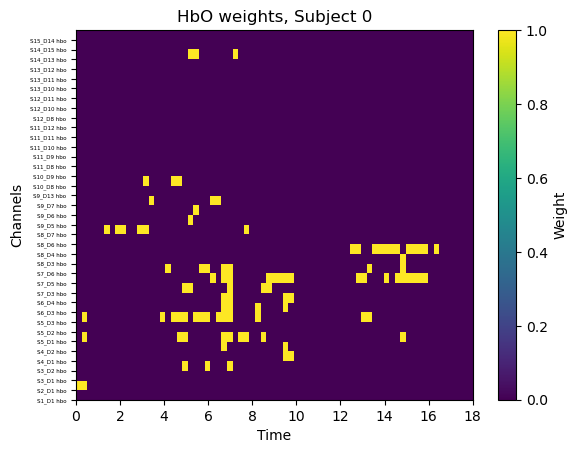

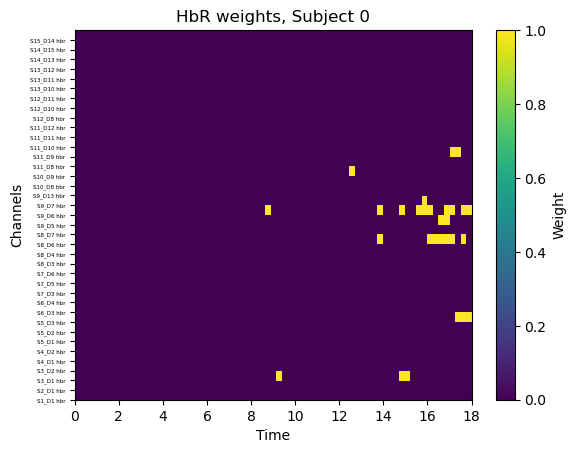

Max hbo value: 3.75, Max hbo index: 24
Max hbr value: 2.25, Max hbr index: 66
Threshold: 3.0
Threshold: 1.8
Value at  23 : 3.25
HBO-First intersection at  23
Value at  25 : 3.5
Second  intersection at  25
Value at  65 : 2.0
HBR-First intersection at  65
Value at  67 : 2.25
Value at  68 : 2.0
Second  intersection at  68
Number of channels at first interseciton for hbo : 3.25
Number of channels at final interseciton for hbo: 3.5
(hbo) First intersection at  23
(hbo) Final intersection at  25
Number of channels at first interseciton for hbr: 2.0
Number of channels at final interseciton for hbr: 2.0
(hbr) First intersection at  65
(hbr) Final intersection at  68
hb0_weights shape: (38, 71)
hbr_weights shape: (38, 71)
Final - Init < 4: 2
Final - Init < 4: 3
Averaged points to make the topographical maps: [23, 27]
len of visual group: 3
Subject: 0
/home/sposso22/mne_data/fNIRS-audio-visual-speech
Loading /home/sposso22/mne_data/fNIRS-audio-visual-speech/sub-02/ses-01/nirs/sub-02_ses-01_task-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


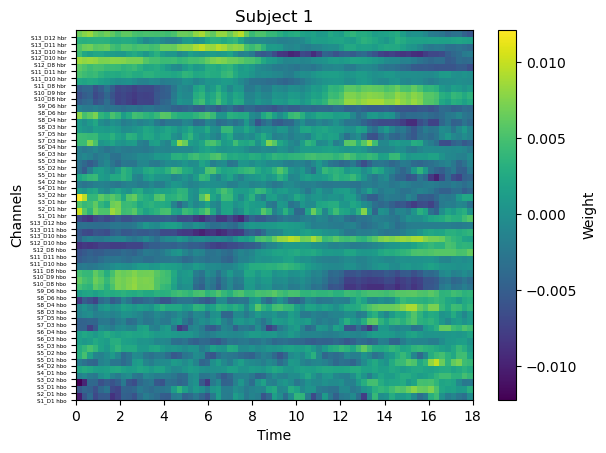

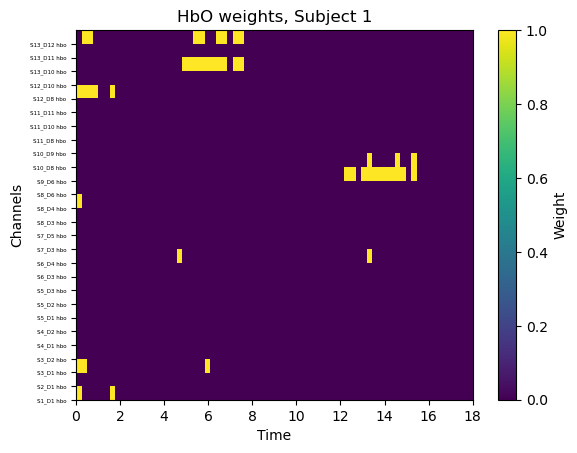

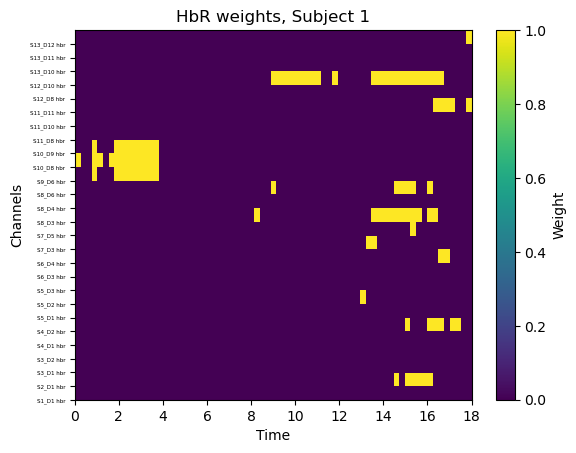

Max hbo value: 1.625, Max hbo index: 23
Max hbr value: 3.875, Max hbr index: 61
Threshold: 1.3
Threshold: 3.1
Value at  22 : 1.5
HBO-First intersection at  22
Value at  24 : 1.5
Second  intersection at  24
Value at  60 : 3.625
Value at  59 : 3.25
HBR-First intersection at  59
Value at  62 : 3.875
Value at  63 : 3.75
Second  intersection at  63
Number of channels at first interseciton for hbo : 1.5
Number of channels at final interseciton for hbo: 1.5
(hbo) First intersection at  22
(hbo) Final intersection at  24
Number of channels at first interseciton for hbr: 3.25
Number of channels at final interseciton for hbr: 3.75
(hbr) First intersection at  59
(hbr) Final intersection at  63
hb0_weights shape: (27, 71)
hbr_weights shape: (27, 71)
Final - Init < 4: 2
Averaged points to make the topographical maps: [22, 26]
Subject: 1
/home/sposso22/mne_data/fNIRS-audio-visual-speech
Loading /home/sposso22/mne_data/fNIRS-audio-visual-speech/sub-03/ses-01/nirs/sub-03_ses-01_task-AudioVisualBroadV

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


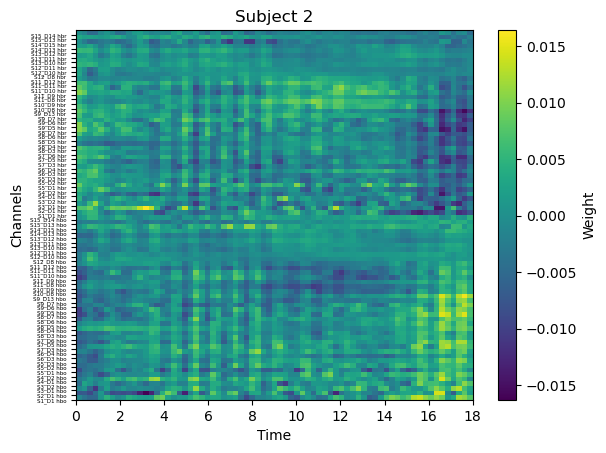

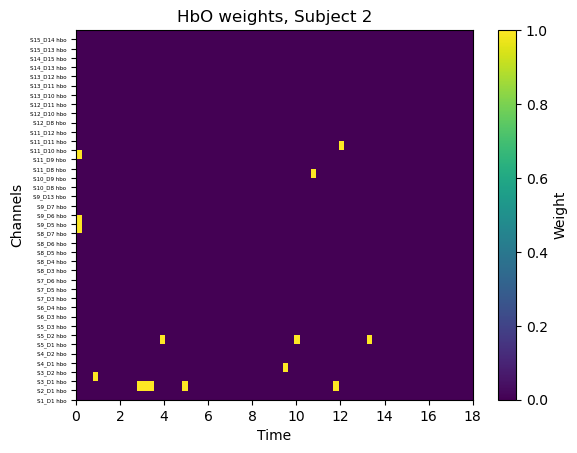

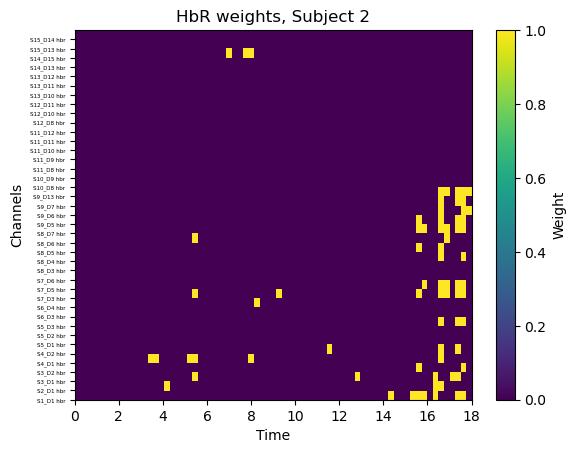

Max hbo value: 0.5, Max hbo index: 0
Max hbr value: 5.75, Max hbr index: 66
Threshold: 0.4
Threshold: 4.6000000000000005
Value at  1 : 0.5
Value at  2 : 0.5
Value at  3 : 0.5
Value at  4 : 0.5
Value at  5 : 0.125
Second  intersection at  5
Value at  65 : 5.125
Value at  64 : 4.0
Value at  63 : 3.875
Value at  62 : 3.25
Value at  61 : 1.625
Value at  60 : 1.375
Value at  59 : 1.375
Value at  58 : 1.0
Value at  57 : 0.25
Value at  56 : 0.125
Value at  55 : 0.125
Value at  54 : 0.25
Value at  53 : 0.25
Value at  52 : 0.125
Value at  51 : 0.125
Value at  50 : 0.125
Value at  49 : 0.25
Value at  48 : 0.25
Value at  47 : 0.25
Value at  46 : 0.125
Value at  45 : 0.125
Value at  44 : 0.125
Value at  43 : 0.125
Value at  42 : 0.125
Value at  41 : 0.0
Value at  40 : 0.125
Value at  39 : 0.125
Value at  38 : 0.125
Value at  37 : 0.125
Value at  36 : 0.25
Value at  35 : 0.5
Value at  34 : 0.625
Value at  33 : 0.625
Value at  32 : 0.5
Value at  31 : 0.625
Value at  30 : 0.625
Value at  29 : 0.625
V

UnboundLocalError: cannot access local variable 'init' where it is not associated with a value

In [129]:
fixed_attention_maps(map_type='threshold')